In [ ]:
%%capture
!pip install datasets tasknet

In [ ]:
%%capture
! pip install -U accelerate
! pip install -U transformers

In [ ]:
#!pip install accelerate -U

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from datasets import load_metric
from transformers import Trainer, TrainingArguments
from google.colab import drive
from datasets import Dataset
import random
import torch
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
seed = 0
validation_indices = random.Random(x=0).sample([i for i in range(100)], 20)

In [ ]:
out = pd.read_csv('/content/drive/MyDrive/regression_transformer/out.csv').reset_index(drop=True)

In [ ]:
train_ds = out.iloc[~out.index.isin(validation_indices)]
test_ds = out.iloc[validation_indices]

In [ ]:
train_ds.shape, test_ds.shape

((80, 6), (20, 6))

In [ ]:
batch_size = 8
learning_rate = 2e-5
weight_decay = 0.01
epochs = 5
num_model = 1
max_length = 505
model_base = "/content/drive/MyDrive/regression_transformer/model_1/checkpoint-50"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def count_tokens(row, tokenizer):
  input_ids = len(tokenizer(row['Simple'])['input_ids'])
  return input_ids

def tokenize(examples, tokenizer):
    return tokenizer(examples["text"], truncation=True, padding='max_length')

#norm 2
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

def preprocess(ds, tokenizer):
  df_new = ds[['Simple', 'AnswerSimple']]
  df_new.columns = ["text","label"]
  print(df_new.head())
  dataset = Dataset.from_pandas(df_new)
  return dataset.map(tokenize, fn_kwargs={"tokenizer": tokenizer}, batched=True)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_base, model_max_length=max_length)
model = AutoModelForSequenceClassification.from_pretrained(model_base, num_labels = 1).to(device)

## load pretrained model from checkpoint

In [ ]:
train_ds['token_length'] = train_ds.apply(lambda x: count_tokens(x, tokenizer), axis = 1)

<ipython-input-30-ffebb9026f69>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ds['token_length'] = train_ds.apply(lambda x: count_tokens(x, tokenizer), axis = 1)


In [ ]:
#train_ds['token_length'].describe()

<Axes: ylabel='token_length'>

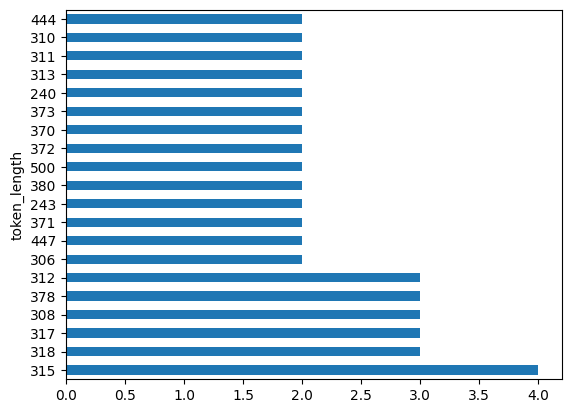

In [ ]:
train_ds['token_length'].value_counts()[:20].plot(kind='barh')

In [ ]:
tokenized_dataset_train, tokenized_dataset_test = preprocess(train_ds.reset_index(drop=True), tokenizer), preprocess(test_ds.reset_index(drop=True), tokenizer)

                                                text     label
0  If someone is not wearing_color, then the prob...  0.404617
1  If someone is not wearing_color, then the prob...  0.418241
2  If someone is not wearing_color, then the prob...  0.557703
3  If someone is not wearing_color, then the prob...  0.557703
4  If someone is not wearing_color, then the prob...  0.557703


Map:   0%|          | 0/80 [00:00<?, ? examples/s]

                                                text     label
0  If someone is not wearing_color, then the prob...  0.557703
1  If someone is not wearing_color, then the prob...  0.557703
2  If someone is not wearing_color, then the prob...  0.404617
3  If someone is not wearing_color, then the prob...  0.557703
4  If someone is not wearing_color, then the prob...  0.404617


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [ ]:
args = TrainingArguments(
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=learning_rate,
    num_train_epochs=epochs,
    report_to="none",
    output_dir=f'/content/drive/MyDrive/regression_transformer/model_{num_model}',
    weight_decay=weight_decay,
    logging_steps = 1,
    logging_dir="./log",
    metric_for_best_model='rmse')

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset= tokenized_dataset_train,
    eval_dataset = tokenized_dataset_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.can_return_loss = True

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rmse
1,0.004100,0.013554,0.116423
2,0.019300,0.010641,0.103156
3,0.016700,0.010625,0.103077
4,0.015100,0.009701,0.098492
5,0.009700,0.006274,0.079211


TrainOutput(global_step=50, training_loss=0.017935664830729364, metrics={'train_runtime': 146.5834, 'train_samples_per_second': 2.729, 'train_steps_per_second': 0.341, 'total_flos': 103804601532000.0, 'train_loss': 0.017935664830729364, 'epoch': 5.0})

In [ ]:
train_ds.AnswerSimple.std()

0.07468423263306183

# Testing the model

In [ ]:
test_ds['Simple'].iloc[0]

'If someone is not wearing_color, then the probability that they are not blue is 0.44229670469666166\nIf someone is not blue and not wearing_color, then the probability that they are not red is 0.5953831213930163\nIf someone is blue and not wearing_color, then the probability that they are red is 0.40461687860698375\nIf someone is wearing_color and not blue, then the probability that they are not red is 0.5953831213930163\nIf someone is blue and wearing_color, then the probability that they are not red is 0.5953831213930163\nIf someone is not wearing_color, then the probability that they are not white is 0.44229670469666166\nIf someone is wearing_color, then the probability that they are white is 0.5577032953033384\nThere is a probability of 0.36186177420161986 that Neimad is wearing_color today.\nIf someone is blue, then the probability that they are wearing_color is 0.36186177420161986\nThere is a probability of 0.36186177420161986 that Neimad is wearing_color today.\nThere is a prob

In [ ]:
test_ds['AnswerSimple'].iloc[0], test_ds['AnswerSimple'].iloc[1]

(0.5577032953033384, 0.5577032953033384)

In [ ]:
phrase = test_ds['Simple'].iloc[1]
tokenized_sentence = tokenizer(phrase, return_tensors='pt').to("cpu")

In [ ]:
model.to("cpu")(**tokenized_sentence).logits[0][0].item()

0.5012671947479248

In [ ]:
%%capture
!pip install tasknet

In [ ]:
import tasknet as tn; from datasets import load_dataset
import datasets

dataset=datasets.DatasetDict(dict(train=Dataset.from_pandas(train_ds),
     test=Dataset.from_pandas(test_ds),
     validation=Dataset.from_pandas(test_ds)))

ours = tn.Classification(
    dataset,
    s1="Simple", y="AnswerSimple")

cladder = tn.AutoTask("cladder", nrows=5000)

class hparams:
  model_name = 'sileod/deberta-v3-base-tasksource-nli' # better performance for most tasks
  learning_rate = 2e-5

for additional in [[],[ours]]:
  model, trainer = tn.Model_Trainer([cladder]+additional,hparams)
  trainer.train(),
  res= trainer.evaluate()

Epoch,Training Loss,Validation Loss,Pearson,Spearmanr,Name,Size,Index
1,0.074600,0.009472,-0.137336,-0.200440,,20,0


Trainer is attempting to log a value of "" of type <class 'str'> for key "eval/name" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


KeyboardInterrupt: 

In [ ]:
train_ds

,Simple,AnswerSimple,Do,AnswerDo,Group,AnswerGroup,token_length
0,"If someone is not wearing_color, then the prob...",0.404617,"If someone is not wearing_color, then the prob...",0.404617,"If someone is not wearing_color, then the prob...",0.874343,318
1,"If someone is not wearing_color, then the prob...",0.418241,"If someone is not wearing_color, then the prob...",0.418241,"If someone is not wearing_color, then the prob...",0.933363,441
2,"If someone is not wearing_color, then the prob...",0.557703,"If someone is not wearing_color, then the prob...",0.557703,"If someone is not wearing_color, then the prob...",0.557703,316
3,"If someone is not wearing_color, then the prob...",0.557703,"If someone is not wearing_color, then the prob...",0.557703,"If someone is not wearing_color, then the prob...",1.000000,313
4,"If someone is not wearing_color, then the prob...",0.557703,"If someone is not wearing_color, then the prob...",0.557703,"If someone is not wearing_color, then the prob...",0.000000,310
...,...,...,...,...,...,...,...
93,"If someone is wearing_color, then the probabil...",0.557703,"If someone is wearing_color, then the probabil...",0.557703,"If someone is wearing_color, then the probabil...",0.173464,307
94,"If someone is not wearing_color, then the prob...",0.418241,"If someone is not wearing_color, then the prob...",0.418241,"If someone is not wearing_color, then the prob...",0.030599,448
95,"If someone is not wearing_color, then the prob...",0.557703,"If someone is not wearing_color, then the prob...",0.557703,"If someone is not wearing_color, then the prob...",0.000000,311
98,"If someone is not wearing_color, then the prob...",0.404617,"If someone is not wearing_color, then the prob...",0.404617,"If someone is not wearing_color, then the prob...",0.066242,308
